# Multi-Class Model for Human Activity Recognition Using TensorFlow Take 2
### David Lowe
### June 11, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Human Activity Recognition Using Smartphones dataset is a multi-class classification situation where we are trying to predict one of several (more than two) possible outcomes.

INTRODUCTION: Researchers collected the datasets from experiments that consist of a group of 30 volunteers, with each person performing six activities by wearing a smartphone on the waist. With its embedded accelerometer and gyroscope, the research captured measurement for the activities of WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING. The dataset has been randomly partitioned into two sets, where 70% of the volunteers were selected for generating the training data and 30% the test data.

In previous iterations, the script focused on evaluating various classic machine learning algorithms and identify the algorithm that produces the best accuracy metric. The previous iterations established a baseline performance in terms of accuracy and processing time.

In iteration Take1, we constructed and tuned an XGBoost machine learning model for this dataset. We also observed the best accuracy result that we could obtain using the XGBoost model with the training and test datasets.

In this Take2 iteration, we will construct several Multilayer Perceptron (MLP) models with one hidden layer. These simple MLP models will serve as the baseline models as we build more complex MLP models in future iterations.

ANALYSIS: For iteration Take1, the XGBoost model achieved an accuracy metric of 99.45% in training. When configured with the optimized parameters, the XGBoost model processed the test dataset with an accuracy of 94.94%, which indicated a high variance issue. We will need to explore regularization techniques or other modeling approaches before deploying the model for production use.

For this Take2 iteration, the one-layer MLP models achieved an accuracy metric of between 98.8% and 99.3% after 50 epochs in training. the same models processed the test datasets with an accuracy metric of between 93.0% and 95.9%.

One-layer 32 nodes: Training - 98.84% Testing - 94.84%
One-layer 64 nodes: Training - 99.22% Testing - 94.40%
One-layer 96 nodes: Training - 99.30% Testing - 95.86%
One-layer 128 nodes: Training - 99.02% Testing - 95.86%
One-layer 192 nodes: Training - 99.27% Testing - 94.63%
One-layer 256 nodes: Training - 99.22% Testing - 95.18%
One-layer 384 nodes: Training - 99.18% Testing - 93.07%
One-layer 512 nodes: Training - 98.93% Testing - 94.23%
One-layer 768 nodes: Training - 99.15% Testing - 94.97%
One-layer 1024 nodes: Training - 99.10% Testing - 94.06%

CONCLUSION: For this iteration, the one-layer MLP models produced mixed results with noticeable variance. For this dataset, We will need to explore regularization techniques or other modeling approaches to reduce variance before deploying the model for production use.

Dataset Used: Human Activity Recognition Using Smartphones

Dataset ML Model: Multi-class classification with numerical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

A deep-learning modeling project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Data
3. Define and Train Model
4. Evaluate and Optimize Model
5. Finalize Model and Make Predictions

# Task 1. Prepare Environment

In [1]:
!pip install python-dotenv PyMySQL

In [2]:
# Retrieve GPU information from Colab
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


In [3]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Sun Jun  7 22:50:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [0]:
# Direct Colab to use TensorFlow v2
%tensorflow_version 2.x

In [0]:
# Set the random seed number for reproducible results
seedNum = 888

In [0]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
# from tensorflow.keras.layers import Flatten
# from tensorflow.keras.layers import Conv2D
# from tensorflow.keras.layers import MaxPooling2D
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
import sys
import smtplib
import matplotlib.pyplot as plt
from datetime import datetime
from email.message import EmailMessage
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [8]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting to True will activate)
# verbose = True
# tf.debugging.set_log_device_placement(verbose)

# Set up the number of CPU cores available for multi-thread processing
# n_jobs = 2
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the number of folds for cross validation
n_folds = 5

# Set the flag for splitting the dataset
splitDataset = False
splitPercentage = 0.25

# Set various default Keras modeling parameters
default_loss = 'categorical_crossentropy'
default_metrics = ['accuracy']
default_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.keras.initializers.he_uniform(seed=seedNum)
default_epoch = 50
default_batch = 32

Num GPUs Available:  1


In [0]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

# Task 2. Load and Prepare Data

## 2.a) Load Dataset

In [10]:
dataset_url = "https://dainesanalytics.com/datasets/ucirvine-human-activity-recognition/"
widthVector = [16] * 561
colNames = ["attr" + str(i).zfill(3) for i in range(1,562)]
X_train_df = pd.read_fwf(dataset_url+'train/X_train.txt', widths=widthVector, header=None, names=colNames)
y_train_df = pd.read_csv(dataset_url+'train/y_train.txt', names=["targetVar"])
Xy_train_df = pd.concat([X_train_df, y_train_df], axis=1)
X_test_df = pd.read_fwf(dataset_url+'test/X_test.txt', widths=widthVector, header=None, names=colNames)
y_test_df = pd.read_csv(dataset_url+'test/y_test.txt', names=["targetVar"])
Xy_test_df = pd.concat([X_test_df, y_test_df], axis=1)
Xy_original = pd.concat([Xy_train_df, Xy_test_df], axis=0)

# Take a peek at the dataframe after the import
Xy_original.head(10)

,attr001,attr002,attr003,attr004,attr005,attr006,attr007,attr008,attr009,attr010,attr011,attr012,attr013,attr014,attr015,attr016,attr017,attr018,attr019,attr020,attr021,attr022,attr023,attr024,attr025,attr026,attr027,attr028,attr029,attr030,attr031,attr032,attr033,attr034,attr035,attr036,attr037,attr038,attr039,attr040,...,attr523,attr524,attr525,attr526,attr527,attr528,attr529,attr530,attr531,attr532,attr533,attr534,attr535,attr536,attr537,attr538,attr539,attr540,attr541,attr542,attr543,attr544,attr545,attr546,attr547,attr548,attr549,attr550,attr551,attr552,attr553,attr554,attr555,attr556,attr557,attr558,attr559,attr560,attr561,targetVar
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,...,-0.991364,-1.0,-0.936508,0.346989,-0.516080,-0.802760,-0.980135,-0.961309,-0.973653,-0.952264,-0.989498,-0.980135,-0.999240,-0.992656,-0.701291,-1.000000,-0.128989,0.586156,0.374605,-0.991990,-0.990697,-0.989941,-0.992448,-0.991048,-0.991990,-0.999937,-0.990458,-0.871306,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,5
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,-0.818409,0.849308,0.685845,0.822637,-0.981930,-0.999991,-0.999788,-0.998405,-0.999150,-0.977866,-0.948225,-0.714892,-0.500930,-0.570979,0.611627,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,-0.281211,0.085988,-0.022153,-0.016657,-0.220643,-0.013429,-0.072692,0.579382,...,-0.991134,-1.0,-0.841270,0.532061,-0.624871,-0.900160,-0.988296,-0.983322,-0.982659,-0.986321,-0.991829,-0.988296,-0.999811,-0.993979,-0.720683,-0.948718,-0.271958,-0.336310,-0.720015,-0.995854,-0.996399,-0.995442,-0.996866,-0.994440,-0.995854,-0.999981,-0.994544,-1.000000,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,5
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,0.682401,0.839344,-0.983478,-0.999969,-0.999660,-0.999470,-0.997130,-0.964810,-0.974675,-0.592235,-0.485821,-0.570979,0.273025,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,-0.332564,0.239281,-0.136204,0.173863,-0.299493,-0.124698,-0.181105,0.608900,...,-0.986658,-1.0,-0.904762,0.660795,-0.724697,-0.928539,-0.989255,-0.986028,-0.984274,-0.990979,-0.995703,-0.989255,-0.999854,-0.993238,-0.736521,-0.794872,-0.212728,-0.535352,-0.871914,-0.995031,-0.995127,-0.994640,-0.996060,-0.995866,-0.995031,-0.999973,-0.993755,-1.000000,-0.555556,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,5
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,-0.576159,-0.829711,0.843609,0.682401,0.837869,-0.986093,-0.999976,-0.999736,-0.999504,-0.997180,-0.983799,-0.986007,-0.627446,-0.850930,-0.911872,0.061436,0.074840,0.198204,-0.264307,0.072545,-0.155320,0.323154,-0.170813,0.294938,-0.306081,0.482148,-0.470129,-0.305693,-0.362654,0.507459,...,-0.988055,-1.0,1.000000,0.678921,-0.701131,-0.909639,-0.989413,-0.987836,-0.986850,-0.986749,-0.996199,-0.989413,-0.999876,-0.989136,-0.720891,-1.000000,-0.035684,-0.230091,-0.511217,-0.995221,-0.995237,-0.995722,-0.995273,-0.995732,-0.995221,-0.999974,-0.995226,-0.955696,-0.936508,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,5
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,-0.569174,-0.824705,0.849095,0.683250,0.837869,-0.992653,-0.999991,-0.999856,-0.999757,-0.998004,-0.981232,-0.991325,-0.786553,-0.559477,-0.761434,0

In [11]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10299 entries, 0 to 2946
Data columns (total 562 columns):
 #   Column     Dtype  
---  ------     -----  
 0   attr001    float64
 1   attr002    float64
 2   attr003    float64
 3   attr004    float64
 4   attr005    float64
 5   attr006    float64
 6   attr007    float64
 7   attr008    float64
 8   attr009    float64
 9   attr010    float64
 10  attr011    float64
 11  attr012    float64
 12  attr013    float64
 13  attr014    float64
 14  attr015    float64
 15  attr016    float64
 16  attr017    float64
 17  attr018    float64
 18  attr019    float64
 19  attr020    float64
 20  attr021    float64
 21  attr022    float64
 22  attr023    float64
 23  attr024    float64
 24  attr025    float64
 25  attr026    float64
 26  attr027    float64
 27  attr028    float64
 28  attr029    float64
 29  attr030    float64
 30  attr031    float64
 31  attr032    float64
 32  attr033    float64
 33  attr034    float64
 34  attr035    float64
 35

In [12]:
null_counts = Xy_original.isnull().sum()
null_counts[null_counts > 0]

Series([], dtype: int64)

In [13]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


## 2.b) Data Cleaning

In [0]:
# Not applicable for this iteration of the project

## 2.c) Feature Scaling and Pre-processing

In [0]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [0]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

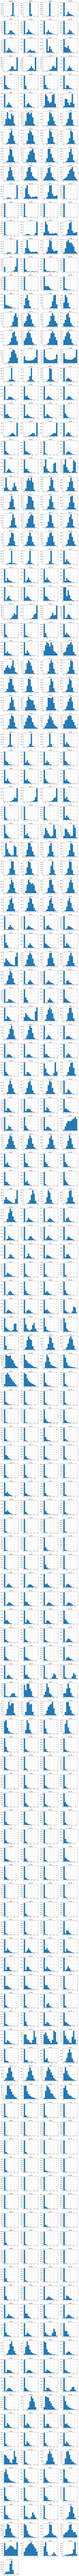

In [17]:
# Histograms for each attribute
X_train_df.hist(layout=(dispRow,dispCol))
plt.show()

## 2.d) Splitting Data into Training and Test Sets

In [18]:
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train_df.shape: (7352, 561) y_train_df.shape: (7352, 1)
X_test_df.shape: (2947, 561) y_test_df.shape: (2947, 1)


In [19]:
# Encode training class values as integers and perform one-hot-encoding
encoder = preprocessing.LabelEncoder()
y_train_array = y_train_df.to_numpy().ravel()
encoder.fit(y_train_array)
y_train_transformed = encoder.transform(y_train_array)
y_train = tf.keras.utils.to_categorical(y_train_transformed)
print(y_train)

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


In [20]:
# Encode testing class values as integers and perform one-hot-encoding
y_test_array = y_test_df.to_numpy().ravel()
encoder.fit(y_test_array)
y_test_transformed = encoder.transform(y_test_array)
y_test = tf.keras.utils.to_categorical(y_test_transformed)
print(y_test)

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


In [21]:
# Finalize the training and testing datasets for the modeling activities
X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()
num_class = y_train.shape[1]

print("X_train.shape: {} X_train.type: {}".format(X_train.shape, type(X_train)))
print("y_train.shape: {} y_train.type: {}".format(y_train.shape, type(y_train)))
print("X_test.shape: {} X_test.type: {}".format(X_test.shape, type(X_test)))
print("y_test.shape: {} y_test.type: {}".format(y_test.shape, type(y_test)))

X_train.shape: (7352, 561) X_train.type: <class 'numpy.ndarray'>
y_train.shape: (7352, 6) y_train.type: <class 'numpy.ndarray'>
X_test.shape: (2947, 561) X_test.type: <class 'numpy.ndarray'>
y_test.shape: (2947, 6) y_test.type: <class 'numpy.ndarray'>


# Task 3. Define and Train Model

In [0]:
# Define the baseline model for benchmarking
def create_default_model():
    default_model = Sequential()
    default_model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(num_class, activation='softmax', kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer, metrics=default_metrics)
    return default_model

In [23]:
startTimeModule = datetime.now()

# Initialize and fit the model
reset_random(seedNum)
baseline_model = create_default_model()
print(baseline_model.get_config())
baseline_hist = baseline_model.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, validation_data=(X_test, y_test), verbose=1)
print('The maximum accuracy for the training dataset:', max(baseline_hist.history['accuracy']))
print('The accuracy at the last epoch for the training dataset:', baseline_hist.history['accuracy'][-1])
print('The maximum accuracy for the test dataset:', max(baseline_hist.history['val_accuracy']))
print('The accuracy at the last epoch for the test dataset:', baseline_hist.history['val_accuracy'][-1])
print('Total time for model fitting:', (datetime.now() - startTimeModule))

{'name': 'sequential', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'batch_input_shape': (None, 561), 'dtype': 'float32', 'units': 32, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_in', 'distribution': 'uniform', 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'dtype': 'float32', 'units': 6, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_in', 'distribution': 'uniform', 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint

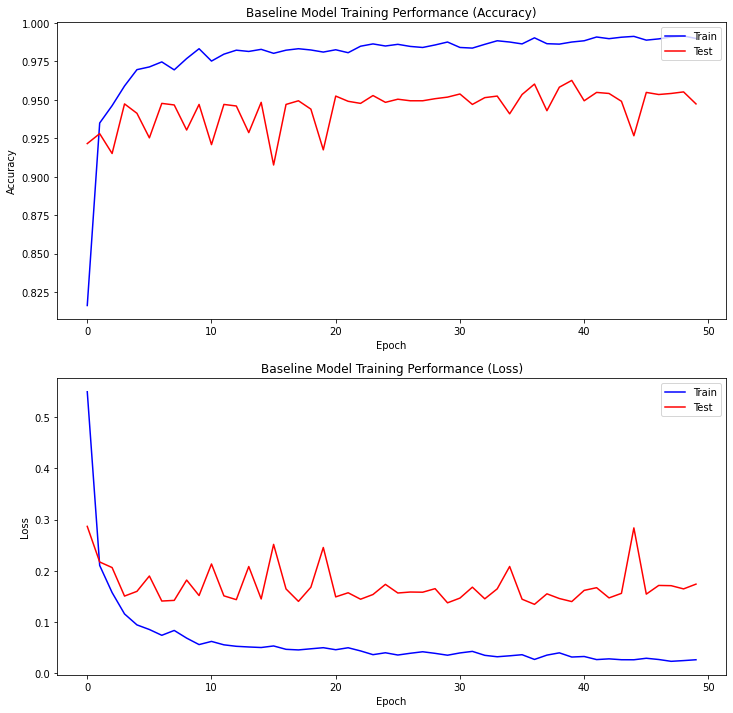

In [24]:
# Summarize model training hisotry
fig, axs = plt.subplots(2, 1, figsize=(12,12))
plt.subplot(211)
plt.plot(baseline_hist.history['accuracy'], color='blue', label='train')
plt.plot(baseline_hist.history['val_accuracy'], color='red', label='test')
plt.title('Baseline Model Training Performance (Accuracy)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.subplot(212)
plt.plot(baseline_hist.history['loss'], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Task 4. Explore Various One-Layer Models

In [25]:
# Define MLP model 4A
def create_model_4A():
    default_model = Sequential()
    default_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(num_class, activation='softmax', kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer, metrics=default_metrics)
    return default_model

# Initialize and fit the model
reset_random(seedNum)
baseline_model_4A = create_model_4A()
print(baseline_model_4A.get_config())
baseline_hist = baseline_model_4A.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, validation_data=(X_test, y_test), verbose=0)
print('The maximum accuracy for the training dataset:', max(baseline_hist.history['accuracy']))
print('The accuracy at the last epoch for the training dataset:', baseline_hist.history['accuracy'][-1])
print('The maximum accuracy for the test dataset:', max(baseline_hist.history['val_accuracy']))
print('The accuracy at the last epoch for the test dataset:', baseline_hist.history['val_accuracy'][-1])
print('Total time for model fitting:', (datetime.now() - startTimeModule))

{'name': 'sequential_1', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense_2', 'trainable': True, 'batch_input_shape': (None, 561), 'dtype': 'float32', 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_in', 'distribution': 'uniform', 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_3', 'trainable': True, 'dtype': 'float32', 'units': 6, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_in', 'distribution': 'uniform', 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constr

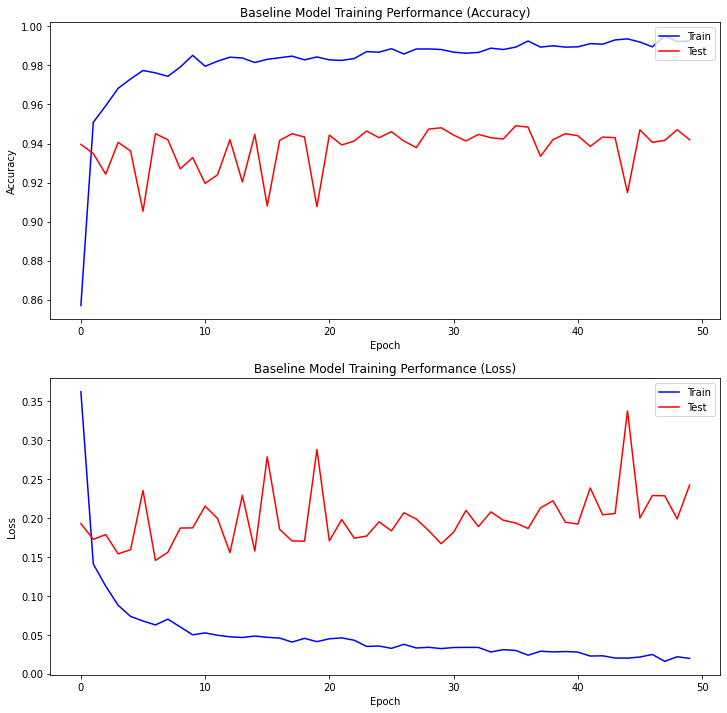

In [26]:
# Summarize model training hisotry
fig, axs = plt.subplots(2, 1, figsize=(12,12))
plt.subplot(211)
plt.plot(baseline_hist.history['accuracy'], color='blue', label='train')
plt.plot(baseline_hist.history['val_accuracy'], color='red', label='test')
plt.title('Baseline Model Training Performance (Accuracy)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.subplot(212)
plt.plot(baseline_hist.history['loss'], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [27]:
# Define MLP model 4B
def create_model_4B():
    default_model = Sequential()
    default_model.add(Dense(96, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(num_class, activation='softmax', kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer, metrics=default_metrics)
    return default_model

# Initialize and fit the model
reset_random(seedNum)
baseline_model_4B = create_model_4B()
print(baseline_model_4B.get_config())
baseline_hist = baseline_model_4B.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, validation_data=(X_test, y_test), verbose=0)
print('The maximum accuracy for the training dataset:', max(baseline_hist.history['accuracy']))
print('The accuracy at the last epoch for the training dataset:', baseline_hist.history['accuracy'][-1])
print('The maximum accuracy for the test dataset:', max(baseline_hist.history['val_accuracy']))
print('The accuracy at the last epoch for the test dataset:', baseline_hist.history['val_accuracy'][-1])
print('Total time for model fitting:', (datetime.now() - startTimeModule))

{'name': 'sequential_2', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense_4', 'trainable': True, 'batch_input_shape': (None, 561), 'dtype': 'float32', 'units': 96, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_in', 'distribution': 'uniform', 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_5', 'trainable': True, 'dtype': 'float32', 'units': 6, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_in', 'distribution': 'uniform', 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constr

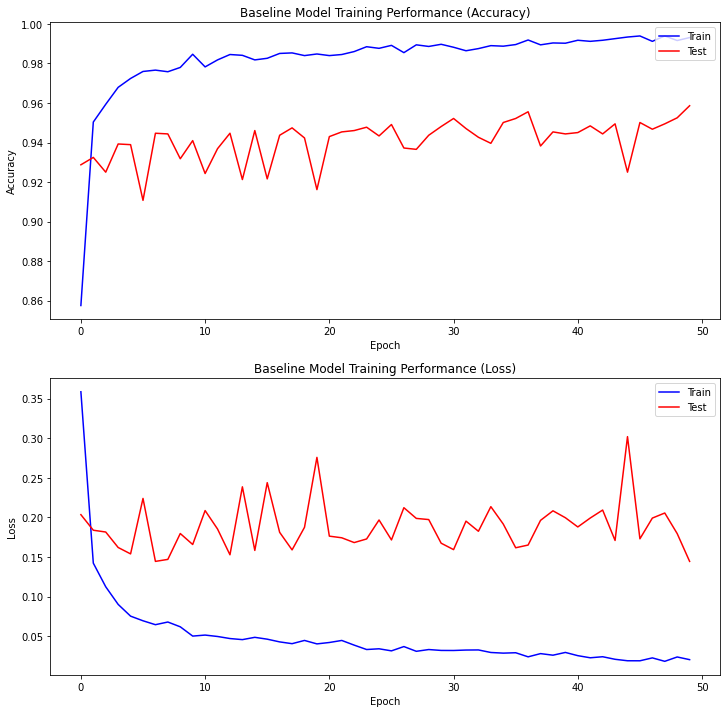

In [28]:
# Summarize model training hisotry
fig, axs = plt.subplots(2, 1, figsize=(12,12))
plt.subplot(211)
plt.plot(baseline_hist.history['accuracy'], color='blue', label='train')
plt.plot(baseline_hist.history['val_accuracy'], color='red', label='test')
plt.title('Baseline Model Training Performance (Accuracy)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.subplot(212)
plt.plot(baseline_hist.history['loss'], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [29]:
# Define MLP model 4C
def create_model_4C():
    default_model = Sequential()
    default_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(num_class, activation='softmax', kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer, metrics=default_metrics)
    return default_model

# Initialize and fit the model
reset_random(seedNum)
baseline_model_4C = create_model_4C()
print(baseline_model_4C.get_config())
baseline_hist = baseline_model_4C.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, validation_data=(X_test, y_test), verbose=0)
print('The maximum accuracy for the training dataset:', max(baseline_hist.history['accuracy']))
print('The accuracy at the last epoch for the training dataset:', baseline_hist.history['accuracy'][-1])
print('The maximum accuracy for the test dataset:', max(baseline_hist.history['val_accuracy']))
print('The accuracy at the last epoch for the test dataset:', baseline_hist.history['val_accuracy'][-1])
print('Total time for model fitting:', (datetime.now() - startTimeModule))

{'name': 'sequential_3', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense_6', 'trainable': True, 'batch_input_shape': (None, 561), 'dtype': 'float32', 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_in', 'distribution': 'uniform', 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_7', 'trainable': True, 'dtype': 'float32', 'units': 6, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_in', 'distribution': 'uniform', 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_const

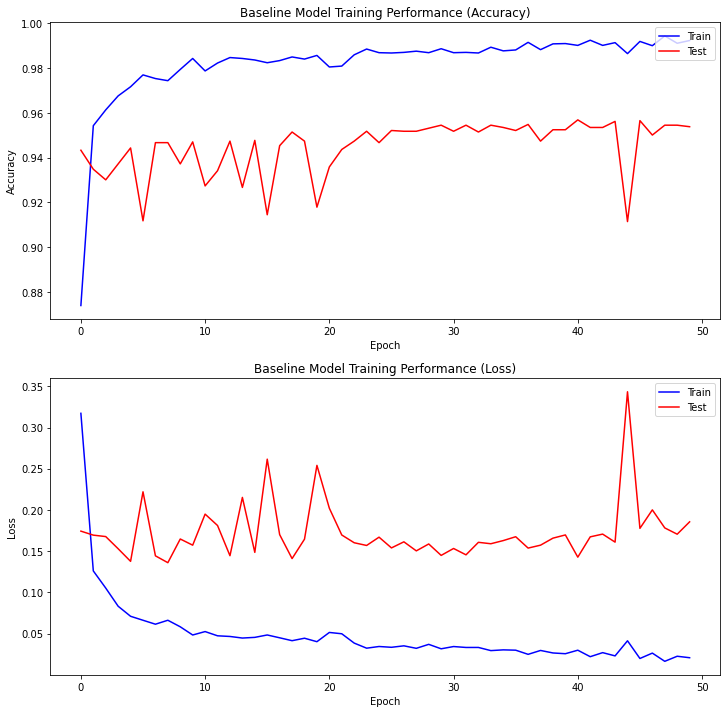

In [30]:
# Summarize model training hisotry
fig, axs = plt.subplots(2, 1, figsize=(12,12))
plt.subplot(211)
plt.plot(baseline_hist.history['accuracy'], color='blue', label='train')
plt.plot(baseline_hist.history['val_accuracy'], color='red', label='test')
plt.title('Baseline Model Training Performance (Accuracy)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.subplot(212)
plt.plot(baseline_hist.history['loss'], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [31]:
# Define MLP model 4D
def create_model_4D():
    default_model = Sequential()
    default_model.add(Dense(192, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(num_class, activation='softmax', kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer, metrics=default_metrics)
    return default_model

# Initialize and fit the model
reset_random(seedNum)
baseline_model_4D = create_model_4D()
print(baseline_model_4D.get_config())
baseline_hist = baseline_model_4D.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, validation_data=(X_test, y_test), verbose=0)
print('The maximum accuracy for the training dataset:', max(baseline_hist.history['accuracy']))
print('The accuracy at the last epoch for the training dataset:', baseline_hist.history['accuracy'][-1])
print('The maximum accuracy for the test dataset:', max(baseline_hist.history['val_accuracy']))
print('The accuracy at the last epoch for the test dataset:', baseline_hist.history['val_accuracy'][-1])
print('Total time for model fitting:', (datetime.now() - startTimeModule))

{'name': 'sequential_4', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense_8', 'trainable': True, 'batch_input_shape': (None, 561), 'dtype': 'float32', 'units': 192, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_in', 'distribution': 'uniform', 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_9', 'trainable': True, 'dtype': 'float32', 'units': 6, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_in', 'distribution': 'uniform', 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_const

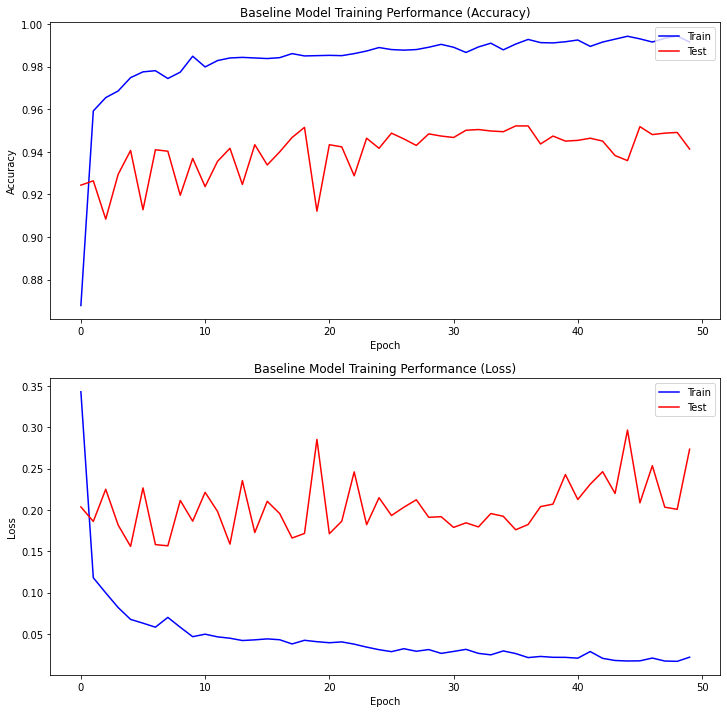

In [32]:
# Summarize model training hisotry
fig, axs = plt.subplots(2, 1, figsize=(12,12))
plt.subplot(211)
plt.plot(baseline_hist.history['accuracy'], color='blue', label='train')
plt.plot(baseline_hist.history['val_accuracy'], color='red', label='test')
plt.title('Baseline Model Training Performance (Accuracy)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.subplot(212)
plt.plot(baseline_hist.history['loss'], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [33]:
# Define MLP model 4E
def create_model_4E():
    default_model = Sequential()
    default_model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(num_class, activation='softmax', kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer, metrics=default_metrics)
    return default_model

# Initialize and fit the model
reset_random(seedNum)
baseline_model_4E = create_model_4E()
print(baseline_model_4E.get_config())
baseline_hist = baseline_model_4E.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, validation_data=(X_test, y_test), verbose=0)
print('The maximum accuracy for the training dataset:', max(baseline_hist.history['accuracy']))
print('The accuracy at the last epoch for the training dataset:', baseline_hist.history['accuracy'][-1])
print('The maximum accuracy for the test dataset:', max(baseline_hist.history['val_accuracy']))
print('The accuracy at the last epoch for the test dataset:', baseline_hist.history['val_accuracy'][-1])
print('Total time for model fitting:', (datetime.now() - startTimeModule))

{'name': 'sequential_5', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense_10', 'trainable': True, 'batch_input_shape': (None, 561), 'dtype': 'float32', 'units': 256, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_in', 'distribution': 'uniform', 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_11', 'trainable': True, 'dtype': 'float32', 'units': 6, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_in', 'distribution': 'uniform', 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_con

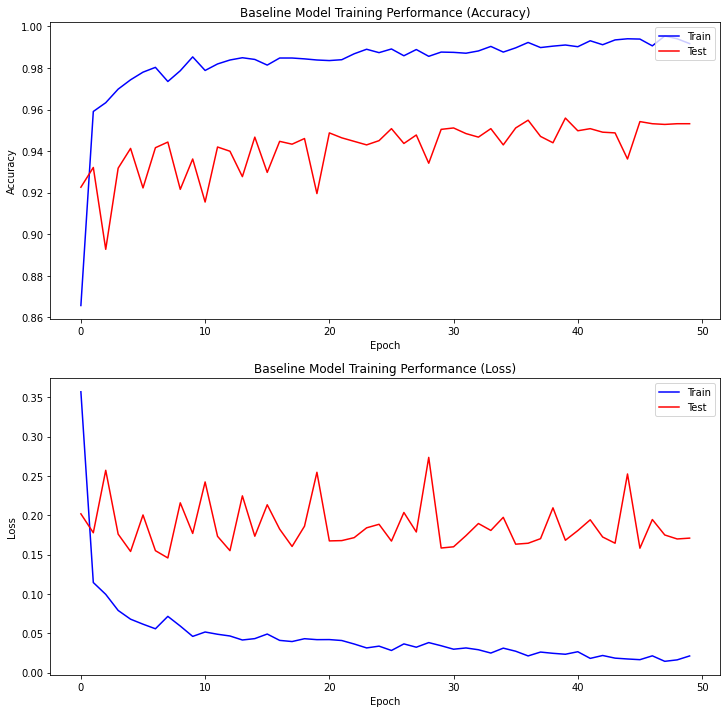

In [34]:
# Summarize model training hisotry
fig, axs = plt.subplots(2, 1, figsize=(12,12))
plt.subplot(211)
plt.plot(baseline_hist.history['accuracy'], color='blue', label='train')
plt.plot(baseline_hist.history['val_accuracy'], color='red', label='test')
plt.title('Baseline Model Training Performance (Accuracy)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.subplot(212)
plt.plot(baseline_hist.history['loss'], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [35]:
# Define MLP model 4F
def create_model_4F():
    default_model = Sequential()
    default_model.add(Dense(384, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(num_class, activation='softmax', kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer, metrics=default_metrics)
    return default_model

# Initialize and fit the model
reset_random(seedNum)
baseline_model_4F = create_model_4F()
print(baseline_model_4F.get_config())
baseline_hist = baseline_model_4F.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, validation_data=(X_test, y_test), verbose=0)
print('The maximum accuracy for the training dataset:', max(baseline_hist.history['accuracy']))
print('The accuracy at the last epoch for the training dataset:', baseline_hist.history['accuracy'][-1])
print('The maximum accuracy for the test dataset:', max(baseline_hist.history['val_accuracy']))
print('The accuracy at the last epoch for the test dataset:', baseline_hist.history['val_accuracy'][-1])
print('Total time for model fitting:', (datetime.now() - startTimeModule))

{'name': 'sequential_6', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense_12', 'trainable': True, 'batch_input_shape': (None, 561), 'dtype': 'float32', 'units': 384, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_in', 'distribution': 'uniform', 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_13', 'trainable': True, 'dtype': 'float32', 'units': 6, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_in', 'distribution': 'uniform', 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_con

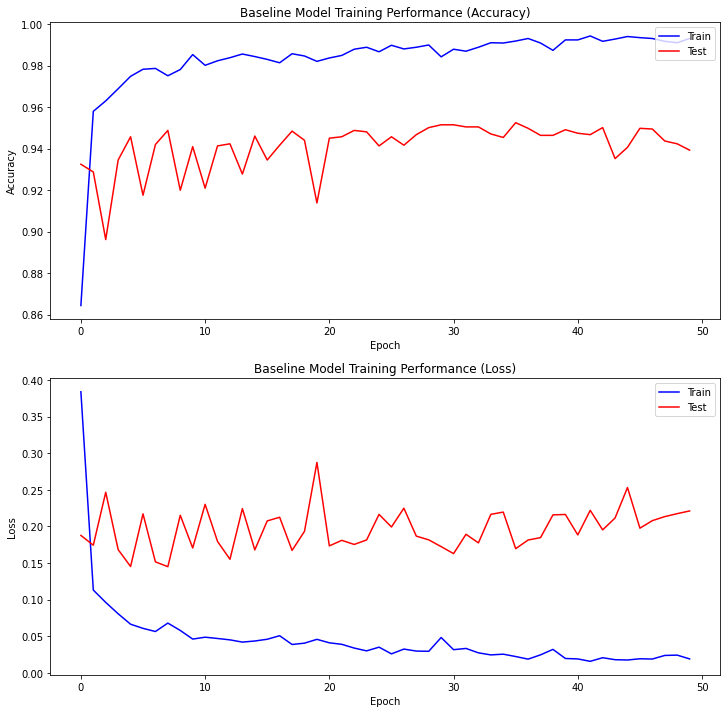

In [36]:
# Summarize model training hisotry
fig, axs = plt.subplots(2, 1, figsize=(12,12))
plt.subplot(211)
plt.plot(baseline_hist.history['accuracy'], color='blue', label='train')
plt.plot(baseline_hist.history['val_accuracy'], color='red', label='test')
plt.title('Baseline Model Training Performance (Accuracy)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.subplot(212)
plt.plot(baseline_hist.history['loss'], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [37]:
# Define MLP model 4G
def create_model_4G():
    default_model = Sequential()
    default_model.add(Dense(512, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(num_class, activation='softmax', kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer, metrics=default_metrics)
    return default_model

# Initialize and fit the model
reset_random(seedNum)
baseline_model_4G = create_model_4G()
print(baseline_model_4G.get_config())
baseline_hist = baseline_model_4G.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, validation_data=(X_test, y_test), verbose=0)
print('The maximum accuracy for the training dataset:', max(baseline_hist.history['accuracy']))
print('The accuracy at the last epoch for the training dataset:', baseline_hist.history['accuracy'][-1])
print('The maximum accuracy for the test dataset:', max(baseline_hist.history['val_accuracy']))
print('The accuracy at the last epoch for the test dataset:', baseline_hist.history['val_accuracy'][-1])
print('Total time for model fitting:', (datetime.now() - startTimeModule))

{'name': 'sequential_7', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense_14', 'trainable': True, 'batch_input_shape': (None, 561), 'dtype': 'float32', 'units': 512, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_in', 'distribution': 'uniform', 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_15', 'trainable': True, 'dtype': 'float32', 'units': 6, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_in', 'distribution': 'uniform', 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_con

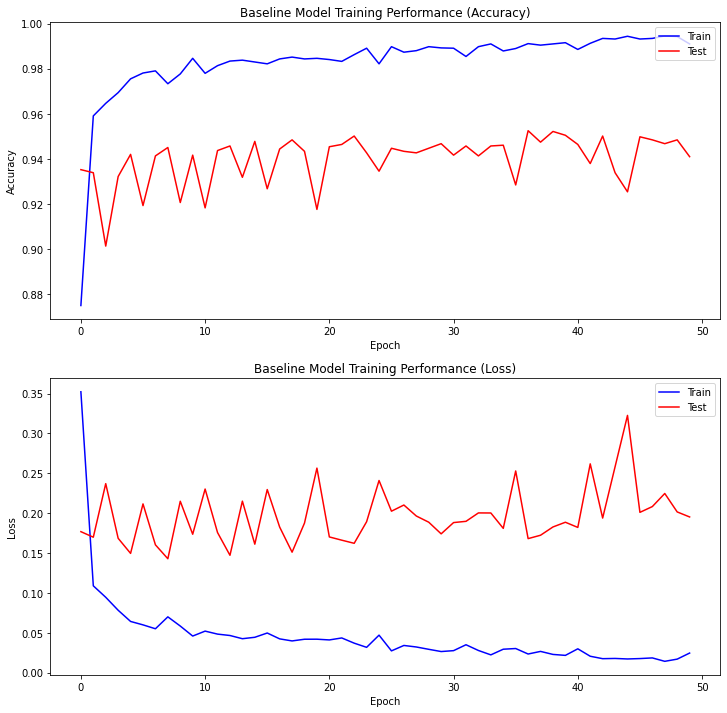

In [38]:
# Summarize model training hisotry
fig, axs = plt.subplots(2, 1, figsize=(12,12))
plt.subplot(211)
plt.plot(baseline_hist.history['accuracy'], color='blue', label='train')
plt.plot(baseline_hist.history['val_accuracy'], color='red', label='test')
plt.title('Baseline Model Training Performance (Accuracy)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.subplot(212)
plt.plot(baseline_hist.history['loss'], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [39]:
# Define MLP model 4H
def create_model_4H():
    default_model = Sequential()
    default_model.add(Dense(768, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(num_class, activation='softmax', kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer, metrics=default_metrics)
    return default_model

# Initialize and fit the model
reset_random(seedNum)
baseline_model_4H = create_model_4H()
print(baseline_model_4H.get_config())
baseline_hist = baseline_model_4H.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, validation_data=(X_test, y_test), verbose=0)
print('The maximum accuracy for the training dataset:', max(baseline_hist.history['accuracy']))
print('The accuracy at the last epoch for the training dataset:', baseline_hist.history['accuracy'][-1])
print('The maximum accuracy for the test dataset:', max(baseline_hist.history['val_accuracy']))
print('The accuracy at the last epoch for the test dataset:', baseline_hist.history['val_accuracy'][-1])
print('Total time for model fitting:', (datetime.now() - startTimeModule))

{'name': 'sequential_8', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense_16', 'trainable': True, 'batch_input_shape': (None, 561), 'dtype': 'float32', 'units': 768, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_in', 'distribution': 'uniform', 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_17', 'trainable': True, 'dtype': 'float32', 'units': 6, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_in', 'distribution': 'uniform', 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_con

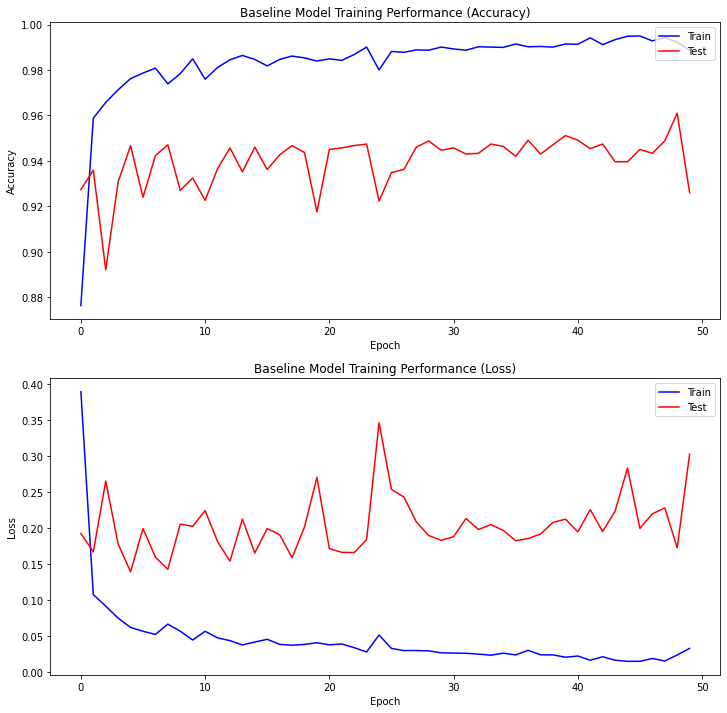

In [40]:
# Summarize model training hisotry
fig, axs = plt.subplots(2, 1, figsize=(12,12))
plt.subplot(211)
plt.plot(baseline_hist.history['accuracy'], color='blue', label='train')
plt.plot(baseline_hist.history['val_accuracy'], color='red', label='test')
plt.title('Baseline Model Training Performance (Accuracy)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.subplot(212)
plt.plot(baseline_hist.history['loss'], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [41]:
# Define MLP model 4I
def create_model_4I():
    default_model = Sequential()
    default_model.add(Dense(1024, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(num_class, activation='softmax', kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer, metrics=default_metrics)
    return default_model

# Initialize and fit the model
reset_random(seedNum)
baseline_model_4I = create_model_4I()
print(baseline_model_4I.get_config())
baseline_hist = baseline_model_4I.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, validation_data=(X_test, y_test), verbose=0)
print('The maximum accuracy for the training dataset:', max(baseline_hist.history['accuracy']))
print('The accuracy at the last epoch for the training dataset:', baseline_hist.history['accuracy'][-1])
print('The maximum accuracy for the test dataset:', max(baseline_hist.history['val_accuracy']))
print('The accuracy at the last epoch for the test dataset:', baseline_hist.history['val_accuracy'][-1])
print('Total time for model fitting:', (datetime.now() - startTimeModule))

{'name': 'sequential_9', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense_18', 'trainable': True, 'batch_input_shape': (None, 561), 'dtype': 'float32', 'units': 1024, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_in', 'distribution': 'uniform', 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_19', 'trainable': True, 'dtype': 'float32', 'units': 6, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_in', 'distribution': 'uniform', 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_co

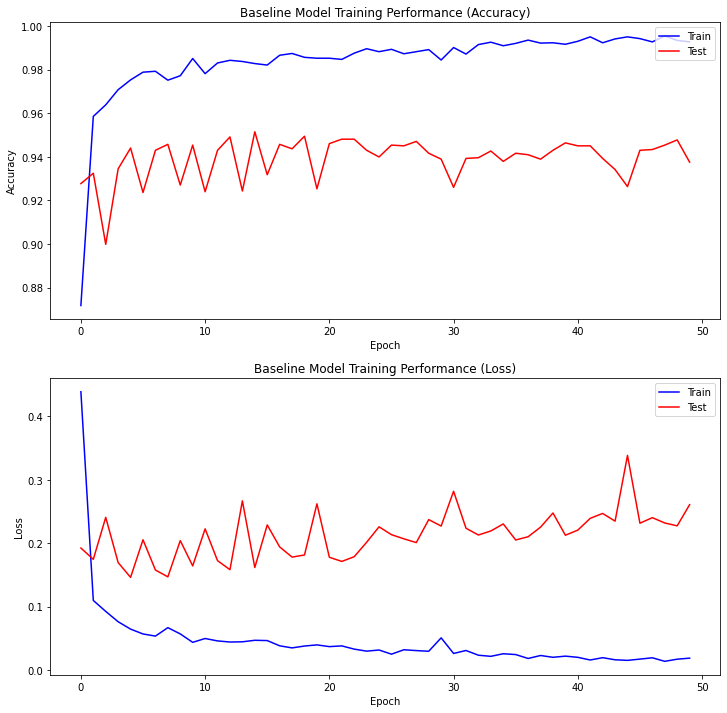

In [42]:
# Summarize model training hisotry
fig, axs = plt.subplots(2, 1, figsize=(12,12))
plt.subplot(211)
plt.plot(baseline_hist.history['accuracy'], color='blue', label='train')
plt.plot(baseline_hist.history['val_accuracy'], color='red', label='test')
plt.title('Baseline Model Training Performance (Accuracy)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.subplot(212)
plt.plot(baseline_hist.history['loss'], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Task 5. Finalize Model and Make Predictions

In [43]:
# Display a summary of the final model
final_model = baseline_model_4C
print(final_model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               71936     
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 774       
Total params: 72,710
Trainable params: 72,710
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
# Display the configuration of the final model
print(final_model.get_config())

{'name': 'sequential_3', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense_6', 'trainable': True, 'batch_input_shape': (None, 561), 'dtype': 'float32', 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_in', 'distribution': 'uniform', 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_7', 'trainable': True, 'dtype': 'float32', 'units': 6, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_in', 'distribution': 'uniform', 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_const

In [45]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:05:26.500392
